In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork

In [2]:
covid_policies_df = pd.read_csv(
    "../data/processed/Final_Data_Combined.csv", index_col=0
)
print(covid_policies_df.shape)
covid_policies_df.head()

(23860, 17)


,Country,Date,school_closures,workplace_closures,cancel_public_events,restrict_public_gathering,closure_public_transport,SHN_requirement,restriction_internal_movement,internation_travel_control,PI_Campaign,testing_policy,contact_tracing,Facial_Covering,Vaccine_policy,Confirmed_cases,Confirmed_Deathes
0,China,2020-05-02,2G,1G,1G,3G,0,0,1G,4.0,2G,3.0,2.0,2G,0,991.0,6.0
1,China,2020-05-03,2G,1G,1G,3G,0,0,1G,4.0,2G,3.0,2.0,2G,0,991.0,6.0
2,China,2020-05-04,2G,1G,1G,3G,0,0,1G,4.0,2G,3.0,2.0,2G,0,991.0,6.0
3,China,2020-05-05,2G,1G,1G,3G,0,0,1G,4.0,2G,3.0,2.0,2G,0,991.0,6.0
4,China,2020-05-06,2G,1G,1G,3G,0,0,1G,4.0,2G,3.0,2.0,2G,0,991.0,6.0


## Preprocessing

In [3]:
covid_policies_df["date"] = pd.to_datetime(covid_policies_df["Date"])
covid_policies_df["Country"] = covid_policies_df["Country"].str.lower()
covid_policies_df["Country"] = covid_policies_df["Country"].str.replace(" ", "_")
covid_policies_df.rename(columns={"Country": "country"}, inplace=True)
covid_policies_df.set_index(["country", "date"], inplace=True)
covid_policies_df.drop(columns=["Date"], inplace=True)
covid_policies_df.rename(
    columns={col: col.lower() for col in covid_policies_df.columns}, inplace=True
)
print(covid_policies_df.shape)
covid_policies_df.head()

(23860, 15)


school_closures workplace_closures cancel_public_events  \
country date                                                                 
china   2020-05-02              2G                 1G                   1G   
        2020-05-03              2G                 1G                   1G   
        2020-05-04              2G                 1G                   1G   
        2020-05-05              2G                 1G                   1G   
        2020-05-06              2G                 1G                   1G   

                   restrict_public_gathering closure_public_transport  \
country date                                                            
china   2020-05-02                        3G                        0   
        2020-05-03                        3G                        0   
        2020-05-04                        3G                        0   
        2020-05-05                        3G                        0   
        2020-05-06                        3G                        0   

                   shn_requirement restriction_internal_movement  \
country date                                                       
china   2020-05-02               0                            1G   
        2020-05-03               0                            1G   
        2020-05-04               0                            1G   
        2020-05-05               0                            1G   
        2020-05-06               0                            1G   

                    internation_travel_control pi_campaign  testing_policy  \
country date                                                                 
china   2020-05-02                         4.0          2G             3.0   
        2020-05-03                         4.0          2G             3.0   
        2020-05-04                         4.0          2G             3.0   
        2020-05-05                         4.0          2G             3.0   
        2020-05-06                         4.0          2G             3.0   

                    contact_tracing facial_covering vaccine_policy  \
country date                                                         
china   2020-05-02              2.0              2G              0   
        2020-05-03              2.0              2G              0   
        2020-05-04              2.0              2G              0   
        2020-05-05              2.0              2G              0   
        2020-05-06              2.0              2G              0   

                    confirmed_cases  confirmed_deathes  
country date                                            
china   2020-05-02            991.0                6.0  
        2020-05-03            991.0                6.0  
        2020-05-04            991.0                6.0  
        2020-05-05            991.0                6.0  
        2020-05-06            991.0                6.0

In [4]:
for column in covid_policies_df.columns:
    print(column, covid_policies_df[column].unique())

school_closures ['2G' '1G' '2T' '3T' '1T' '3G' '0']
workplace_closures ['1G' '2T' '2G' '3T' '1T' '3G' '0']
cancel_public_events ['1G' '2T' '2G' '1T' '0']
restrict_public_gathering ['3G' '2G' '4G' '1G' '3T' '4T' '0' '2T' '1T']
closure_public_transport ['0' '1G' '1T' '2T' '2G']
shn_requirement ['0' '3T' '1G' '2G' '2T' '1T']
restriction_internal_movement ['1G' '2T' '2G' '1T' '0']
internation_travel_control [4. 2. 3. 1.]
pi_campaign ['2G' '0']
testing_policy [3. 2. 1.]
contact_tracing [2. 0. 1.]
facial_covering ['2G' '4G' '3T' '3G' '4T' '1G']
vaccine_policy ['0' '2G' '1G' '5G' '4G' '3G']
confirmed_cases [   991.    992.    993. ... 679795. 696652. 710880.]
confirmed_deathes [  6.   9.   1. ... 963. 975. 986.]


In [5]:
for column in covid_policies_df.columns:
    if pd.api.types.is_numeric_dtype(covid_policies_df[column].dtype):
        continue

    covid_policies_df[column] = (
        covid_policies_df[column].apply(lambda v: v[:1]).astype("int16")
    )

display(covid_policies_df.info())
covid_policies_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23860 entries, ('china', Timestamp('2020-05-02 00:00:00')) to ('singapore', Timestamp('2022-02-27 00:00:00'))
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   school_closures                23860 non-null  int16  
 1   workplace_closures             23860 non-null  int16  
 2   cancel_public_events           23860 non-null  int16  
 3   restrict_public_gathering      23860 non-null  int16  
 4   closure_public_transport       23860 non-null  int16  
 5   shn_requirement                23860 non-null  int16  
 6   restriction_internal_movement  23860 non-null  int16  
 7   internation_travel_control     23860 non-null  float64
 8   pi_campaign                    23860 non-null  int16  
 9   testing_policy                 23860 non-null  float64
 10  contact_tracing                23860 non-null  float64
 11  facial_covering       

None

school_closures  workplace_closures  cancel_public_events  \
country date                                                                    
china   2020-05-02                2                   1                     1   
        2020-05-03                2                   1                     1   
        2020-05-04                2                   1                     1   
        2020-05-05                2                   1                     1   
        2020-05-06                2                   1                     1   

                    restrict_public_gathering  closure_public_transport  \
country date                                                              
china   2020-05-02                          3                         0   
        2020-05-03                          3                         0   
        2020-05-04                          3                         0   
        2020-05-05                          3                         0   
        2020-05-06                          3                         0   

                    shn_requirement  restriction_internal_movement  \
country date                                                         
china   2020-05-02                0                              1   
        2020-05-03                0                              1   
        2020-05-04                0                              1   
        2020-05-05                0                              1   
        2020-05-06                0                              1   

                    internation_travel_control  pi_campaign  testing_policy  \
country date                                                                  
china   2020-05-02                         4.0            2             3.0   
        2020-05-03                         4.0            2             3.0   
        2020-05-04                         4.0            2             3.0   
        2020-05-05                         4.0            2             3.0   
        2020-05-06                         4.0            2             3.0   

                    contact_tracing  facial_covering  vaccine_policy  \
country date                                                           
china   2020-05-02              2.0                2               0   
        2020-05-03              2.0                2               0   
        2020-05-04              2.0                2               0   
        2020-05-05              2.0                2               0   
        2020-05-06              2.0                2               0   

                    confirmed_cases  confirmed_deathes  
country date                                            
china   2020-05-02            991.0                6.0  
        2020-05-03            991.0                6.0  
        2020-05-04            991.0                6.0  
        2020-05-05            991.0                6.0  
        2020-05-06            991.0                6.0

## Add Features

In [6]:
country_to_population_map = {
    "hong_kong": 7500000,
    "china": 1448000000,
    "indonesia": 272000000,
    "singapore": 5450000,
    "malaysia": 32000000,
}

In [7]:
def compute_cases_bin(cases_per_mil):
    computed_bin = None
    if cases_per_mil <= 10000:
        computed_bin = 0
    elif cases_per_mil < 30000:
        computed_bin = 1
    elif cases_per_mil < 50000:
        computed_bin = 2
    elif cases_per_mil < 70000:
        computed_bin = 3
    elif cases_per_mil < 100000:
        computed_bin = 4
    elif cases_per_mil < 120000:
        computed_bin = 5
    else:
        computed_bin = 6

    return computed_bin

covid_policies_df["cases_per_mil"] = covid_policies_df.apply(lambda row: (row.confirmed_cases * 1000000)/ country_to_population_map[row.name[0]], axis=1)
covid_policies_df["cases_per_mil_cat"] = covid_policies_df["cases_per_mil"].apply(compute_cases_bin)
print(covid_policies_df.shape)
covid_policies_df.head()

(23860, 17)


school_closures  workplace_closures  cancel_public_events  \
country date                                                                    
china   2020-05-02                2                   1                     1   
        2020-05-03                2                   1                     1   
        2020-05-04                2                   1                     1   
        2020-05-05                2                   1                     1   
        2020-05-06                2                   1                     1   

                    restrict_public_gathering  closure_public_transport  \
country date                                                              
china   2020-05-02                          3                         0   
        2020-05-03                          3                         0   
        2020-05-04                          3                         0   
        2020-05-05                          3                         0   
        2020-05-06                          3                         0   

                    shn_requirement  restriction_internal_movement  \
country date                                                         
china   2020-05-02                0                              1   
        2020-05-03                0                              1   
        2020-05-04                0                              1   
        2020-05-05                0                              1   
        2020-05-06                0                              1   

                    internation_travel_control  pi_campaign  testing_policy  \
country date                                                                  
china   2020-05-02                         4.0            2             3.0   
        2020-05-03                         4.0            2             3.0   
        2020-05-04                         4.0            2             3.0   
        2020-05-05                         4.0            2             3.0   
        2020-05-06                         4.0            2             3.0   

                    contact_tracing  facial_covering  vaccine_policy  \
country date                                                           
china   2020-05-02              2.0                2               0   
        2020-05-03              2.0                2               0   
        2020-05-04              2.0                2               0   
        2020-05-05              2.0                2               0   
        2020-05-06              2.0                2               0   

                    confirmed_cases  confirmed_deathes  cases_per_mil  \
country date                                                            
china   2020-05-02            991.0                6.0       0.684392   
        2020-05-03            991.0                6.0       0.684392   
        2020-05-04            991.0                6.0       0.684392   
        2020-05-05            991.0                6.0       0.684392   
        2020-05-06            991.0                6.0       0.684392   

                    cases_per_mil_cat  
country date                           
china   2020-05-02                  0  
        2020-05-03                  0  
        2020-05-04                  0  
        2020-05-05                  0  
        2020-05-06                  0

In [8]:
# covid_policies_df.to_csv("../data/processed/categorical_policies.csv")

In [9]:
sg_filtered = covid_policies_df.loc[
    "singapore",
    [
        "school_closures",
        "workplace_closures",
        #         "cancel_public_events",
        #         "restrict_public_gathering",
        #         "closure_public_transport",
        "cases_per_mil",
        "cases_per_mil_cat",
        "confirmed_cases",
    ],
]
sg_filtered.head()

,school_closures,workplace_closures,cases_per_mil,cases_per_mil_cat,confirmed_cases
date,,,,,
2020-05-02,3,3,3219.816514,0,17548.0
2020-05-03,3,3,3340.366972,0,18205.0
2020-05-04,3,3,3445.504587,0,18778.0
2020-05-05,3,3,3561.467890,0,19410.0
2020-05-06,3,3,3706.055046,0,20198.0


In [10]:
ml_filtered = covid_policies_df.loc[
    "malaysia",
    [
        "school_closures",
        "workplace_closures",
        #         "cancel_public_events",
        #         "restrict_public_gathering",
        #         "closure_public_transport",
        "cases_per_mil",
        "cases_per_mil_cat",
        "confirmed_cases",
    ],
]

ml_filtered.head()

,school_closures,workplace_closures,cases_per_mil,cases_per_mil_cat,confirmed_cases
date,,,,,
2020-05-02,3,3,193.00000,0,6176.0
2020-05-03,3,3,196.81250,0,6298.0
2020-05-04,3,2,198.53125,0,6353.0
2020-05-05,3,2,199.46875,0,6383.0
2020-05-06,3,2,200.87500,0,6428.0


<AxesSubplot:xlabel='cases_per_mil', ylabel='Count'>

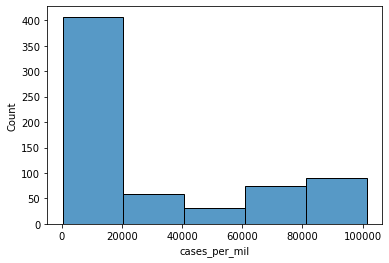

In [11]:
import seaborn as sns

sns.histplot(ml_filtered.cases_per_mil, bins=5)

In [12]:
# from pgmpy.estimators import PC

# est = PC(data=sg_filtered[["school_closures", "workplace_closures", "cases_per_mil_cat"]].iloc[:500], )
# res = est.estimate(max_cond_vars=3)
# import networkx as nx

# nx.draw(res, with_labels=True)

## Contruct DGM with a subset of features

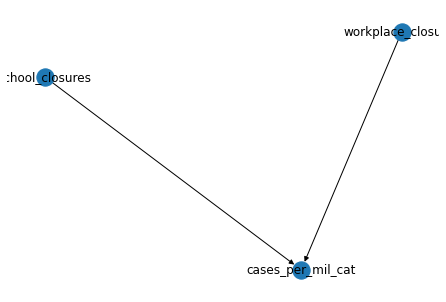

In [13]:
import networkx as nx
from pgmpy.models import BayesianNetwork

sample_model = BayesianNetwork(
    [
        ("school_closures", "cases_per_mil_cat"),
        ("workplace_closures", "cases_per_mil_cat"),
    ]
)
nx.draw(sample_model, with_labels=True)

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    ml_filtered[["school_closures", "workplace_closures"]],
    ml_filtered[["cases_per_mil_cat"]],
)
x_train.shape, x_test.shape

((495, 2), (166, 2))

In [15]:
y_train.cases_per_mil_cat.value_counts()

0    225
4    114
1    100
3     30
2     24
5      2
Name: cases_per_mil_cat, dtype: int64

In [16]:
y_test.cases_per_mil_cat.value_counts()

0    89
1    32
4    29
2    10
3     6
Name: cases_per_mil_cat, dtype: int64

In [17]:
from pgmpy.estimators import MaximumLikelihoodEstimator

sample_model.fit(pd.concat([x_train, y_train], axis=1), MaximumLikelihoodEstimator)

In [18]:
for cpd in sample_model.get_cpds():
    print(cpd)

+--------------------+-----------+
| school_closures(0) | 0.0585859 |
+--------------------+-----------+
| school_closures(1) | 0.0545455 |
+--------------------+-----------+
| school_closures(2) | 0.363636  |
+--------------------+-----------+
| school_closures(3) | 0.523232  |
+--------------------+-----------+
+----------------------+-----+-----------------------+
| school_closures      | ... | school_closures(3)    |
+----------------------+-----+-----------------------+
| workplace_closures   | ... | workplace_closures(3) |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(0) | ... | 0.8202247191011236    |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(1) | ... | 0.0                   |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(2) | ... | 0.1797752808988764    |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(3) | ... | 0.0                   |
+----------------------+-

In [19]:
from pgmpy.inference import VariableElimination

ve = VariableElimination(sample_model)

print(
    ve.query(
        ["cases_per_mil_cat"], evidence={"school_closures": 2, "workplace_closures": 1}
    )
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----------------------+--------------------------+
| cases_per_mil_cat    |   phi(cases_per_mil_cat) |
+======================+==========================+
| cases_per_mil_cat(0) |                   0.0000 |
+----------------------+--------------------------+
| cases_per_mil_cat(1) |                   0.0000 |
+----------------------+--------------------------+
| cases_per_mil_cat(2) |                   0.0000 |
+----------------------+--------------------------+
| cases_per_mil_cat(3) |                   0.0361 |
+----------------------+--------------------------+
| cases_per_mil_cat(4) |                   0.9639 |
+----------------------+--------------------------+
| cases_per_mil_cat(5) |                   0.0000 |
+----------------------+--------------------------+


## Influence of Singapore's policies on Malaysia's policies

In [20]:
two_country_df = covid_policies_df.reset_index()
two_country_df = two_country_df[two_country_df.country.isin(["malaysia", "singapore"])]
two_country_df = two_country_df.reset_index(drop=True)
two_country_df = two_country_df[["country", "date", "school_closures", "workplace_closures"]].copy()
transformed_dfs = []
for country in two_country_df.country.unique():
    filter_df = two_country_df[two_country_df.country == country].copy()
    filter_df.rename(
        columns={
            col: country + "_" + col
            for col in ["school_closures", "workplace_closures"]
        },
        inplace=True,
    )
    filter_df.drop(["country"], axis=1, inplace=True)
    transformed_dfs.append(filter_df)

In [21]:
merged_df = pd.merge(transformed_dfs[0], transformed_dfs[1], on=["date"])
merged_df.set_index(["date"], inplace=True)
merged_df

,malaysia_school_closures,malaysia_workplace_closures,singapore_school_closures,singapore_workplace_closures
date,,,,
2020-05-02,3,3,3,3
2020-05-03,3,3,3,3
2020-05-04,3,2,3,3
2020-05-05,3,2,3,3
2020-05-06,3,2,3,3
...,...,...,...,...
2022-02-17,2,2,1,3
2022-02-18,2,2,1,3
2022-02-19,2,2,1,3


In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    merged_df[["malaysia_school_closures", "singapore_school_closures"]],
    merged_df[["malaysia_workplace_closures", "singapore_workplace_closures"]],
)
x_train.shape, x_test.shape

((495, 2), (166, 2))

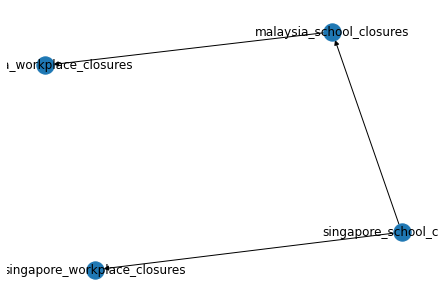

In [28]:
# 2 country model for economic policy effect analysis
two_country_model = BayesianNetwork(
    [
        ("singapore_school_closures", "malaysia_school_closures"),
        ("singapore_school_closures", "singapore_workplace_closures"),
        ("malaysia_school_closures", "malaysia_workplace_closures"),
    ]
)
two_country_model.fit(pd.concat([x_train, y_train], axis=1), MaximumLikelihoodEstimator)
nx.draw(two_country_model, with_labels=True)

In [29]:
for cpd in two_country_model.get_cpds():
    print(cpd)

+------------------------------+-----------+
| singapore_school_closures(1) | 0.826263  |
+------------------------------+-----------+
| singapore_school_closures(2) | 0.0565657 |
+------------------------------+-----------+
| singapore_school_closures(3) | 0.117172  |
+------------------------------+-----------+
+-----------------------------+-----+------------------------------+
| singapore_school_closures   | ... | singapore_school_closures(3) |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(0) | ... | 0.27586206896551724          |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(1) | ... | 0.0                          |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(2) | ... | 0.0                          |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(3) | ... | 0.7241379310344828        

In [24]:
pd.concat([x_test, y_test], axis=1)

,malaysia_school_closures,singapore_school_closures,malaysia_workplace_closures,singapore_workplace_closures
date,,,,
2020-06-20,3,1,2,2
2021-05-31,3,3,2,2
2021-01-25,3,1,3,2
2021-02-06,3,1,3,2
2020-11-10,3,1,3,2
...,...,...,...,...
2020-08-14,2,1,3,2
2020-07-30,1,1,2,2
2022-02-16,2,1,2,3


In [25]:
from pgmpy.inference import VariableElimination

ve = VariableElimination(two_country_model)

print(
    ve.query(
        ["malaysia_workplace_closures"], evidence={"malaysia_school_closures": 2}
    )
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------------------------+------------------------------------+
| malaysia_workplace_closures    |   phi(malaysia_workplace_closures) |
+================================+====================================+
| malaysia_workplace_closures(1) |                             0.4464 |
+--------------------------------+------------------------------------+
| malaysia_workplace_closures(2) |                             0.2262 |
+--------------------------------+------------------------------------+
| malaysia_workplace_closures(3) |                             0.3274 |
+--------------------------------+------------------------------------+
